In [1]:
import re
from datetime import datetime, timedelta
from pathlib import Path
from typing import Optional

import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

from myutils.matplotlib import seaborn_theme, matplotlib_svg

seaborn_theme()
# matplotlib_svg()

## Базовая реструктуризация данных

## Препроцессинг

In [2]:
data = pd.read_csv('../data/data_raw.csv', parse_dates=['date'], encoding='utf-8')

data.head(2)

,date,days,places,price,num,class,train
0,2021-04-03,1,62.0,3275.0,001А,Купе,001А-Купе
1,2021-04-04,1,33.0,3913.0,001А,Купе,001А-Купе


In [3]:
data['train'].nunique()

144

### Добавляем данные о поездах

In [4]:
train_data = pd.concat([
    pd.read_csv('../data/train_data_spb_msk.csv'),
    pd.read_csv('../data/train_data_nizh_msk.csv'),
])
train_data.head(2)

,num,departure_time,travel_time
0,001А,23:55,08:00
1,003А,23:30,09:00


In [9]:
31.4123 % 24

7.412299999999998

In [10]:
def to_timestamp(time: str) -> int:
    hour, minute = time.split(':')
    hour = int(hour)
    minute = int(minute)
    
    # timestamp = (hour * 60 + minute) * 60
    timestamp = hour + minute / 60
        
    return timestamp


train_data['departure_timestamp'] = train_data['departure_time'].apply(to_timestamp)
train_data['arrival_timestamp'] = (train_data['departure_timestamp'] \
    + train_data['travel_time'].apply(to_timestamp)) % 24

train_data.head(2)

,num,departure_time,travel_time,departure_timestamp,arrival_timestamp
0,001А,23:55,08:00,23.916667,7.916667
1,003А,23:30,09:00,23.500000,8.500000


In [11]:
data = data.merge(
    train_data[['num', 'departure_timestamp', 'arrival_timestamp']],
    on='num',
    how='left',
)

data.head(2)

,date,days,places,price,num,class,train,departure_timestamp,arrival_timestamp
0,2021-04-03,1,62.0,3275.0,001А,Купе,001А-Купе,23.916667,7.916667
1,2021-04-04,1,33.0,3913.0,001А,Купе,001А-Купе,23.916667,7.916667


In [12]:
data.loc[data['departure_timestamp'].isna(), 'num'].unique()

array(['702Н', '704Н', '706Н', '708Н', '709Н', '710Н'], dtype=object)

### Удаляем данные за праздники (29 апреля — 12 мая)

In [13]:
holidays = np.arange(
    datetime(year=2021, month=4, day=29),
    datetime(year=2021, month=5, day=13),
    timedelta(days=1),
)

data = data[~data['date'].isin(holidays)].copy()

data.head(2)

,date,days,places,price,num,class,train,departure_timestamp,arrival_timestamp
0,2021-04-03,1,62.0,3275.0,001А,Купе,001А-Купе,23.916667,7.916667
1,2021-04-04,1,33.0,3913.0,001А,Купе,001А-Купе,23.916667,7.916667


### Заполненность строк для разных поездов

In [14]:
dates = data['date'].drop_duplicates().sort_values().values

split_id = np.where(dates > holidays[-1])[0][0]

In [15]:
def date_formatter(dt: datetime) -> str:
    return dt.strftime('%b %d (%a)')

In [54]:
filled_frac = pd.DataFrame({
    train: data[(data['train'] == train) & (data['days'] <= 30)]\
                    .pivot(index='date', columns='days', values='places')\
                    .notna().mean(axis=1)
    for train in sorted(data['train'].unique())
}).reindex(dates).fillna(0)

filled_frac.head(2)

,001А-Купе,001А-СВ,002А-Купе,002А-СВ,003А-Купе,003А-СВ,004А-Купе,004А-СВ,005А-Купе,005А-СВ,...,778А-C1,778А-C2,779А-B1,779А-B2,779А-C1,779А-C2,780А-B1,780А-B2,780А-C1,780А-C2
date,,,,,,,,,,,,,,,,,,,,,
2021-04-03,0.333333,0.333333,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000,0.333333,0.333333,...,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
2021-04-04,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667,...,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667


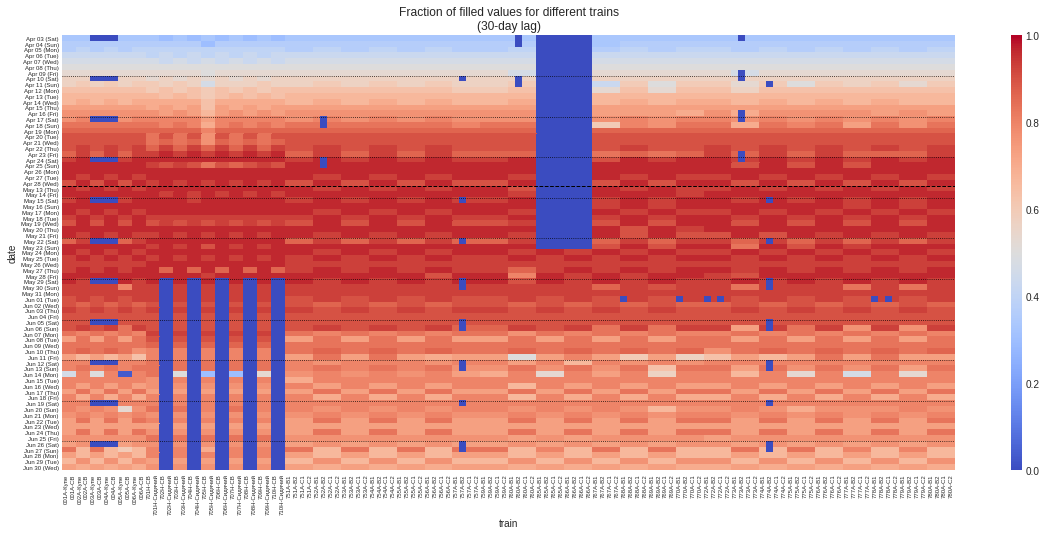

In [55]:
filled_frac_ = filled_frac.copy()
filled_frac_.index = filled_frac_.index.map(date_formatter)

ax = plt.figure(figsize=(20, 8)).gca()
sns.heatmap(filled_frac_, vmin=0, vmax=1, ax=ax, xticklabels=True, yticklabels=True,
            cmap='coolwarm', cbar_kws={'aspect': 40})

ax.axhline(split_id, c='k', ls='dashed', lw=1)

for i in np.arange(0, filled_frac_.shape[0], 7)[1:]:
    ax.axhline(i, c='k', ls='dotted', lw=0.8)

ax.set_xlabel('train')
ax.tick_params(axis='both', which='major', labelsize=6)

ax.set_title('Fraction of filled values for different trains\n'
             '(30-day lag)')

plt.savefig('../data/figures/filled_frac.pdf', transparent=True, bbox_inches='tight')
# plt.close()

### Удаляем поезда, по которым слишком мало данных

__Важно!__ Надо не забыть, что мы не просто выкидываем данные, а планируем рассмотреть их отдельно, когда данных станет больше.

In [51]:
train_nums_to_remove = ['761А', '762А', '763А', '764А']

mask = data['num'].isin(train_nums_to_remove)
data = data[~mask].copy()

mask.sum(), data['train'].nunique()

(0, 128)

In [52]:
train_nums_to_remove = ['765А', '766А']
date = datetime(year=2021, month=5, day=24)

mask = (data['num'].isin(train_nums_to_remove) & (data['date'] < date))
data = data[~mask].copy()

mask.sum(), data['train'].nunique()

(0, 128)

In [56]:
filled_frac_melt = filled_frac.reset_index()\
    .melt(id_vars='date', var_name='train', value_name='filled_frac')\
    .set_index(['train', 'date'])['filled_frac']

filled_frac_melt

train      date      
001А-Купе  2021-04-03    0.333333
           2021-04-04    0.366667
           2021-04-05    0.366667
           2021-04-06    0.433333
           2021-04-07    0.466667
                           ...   
780А-C2    2021-06-26    0.766667
           2021-06-27    0.666667
           2021-06-28    0.666667
           2021-06-29    0.766667
           2021-06-30    0.700000
Name: filled_frac, Length: 9600, dtype: float64

In [62]:
mask = filled_frac_melt <= 0.6

for train, date in tqdm(filled_frac_melt[mask].index):
    mask_ = ((data['train'] == train) & (data['date'] == date))
    
    data = data[~mask_].copy()

mask.sum(), data['train'].nunique()

(1864, 128)

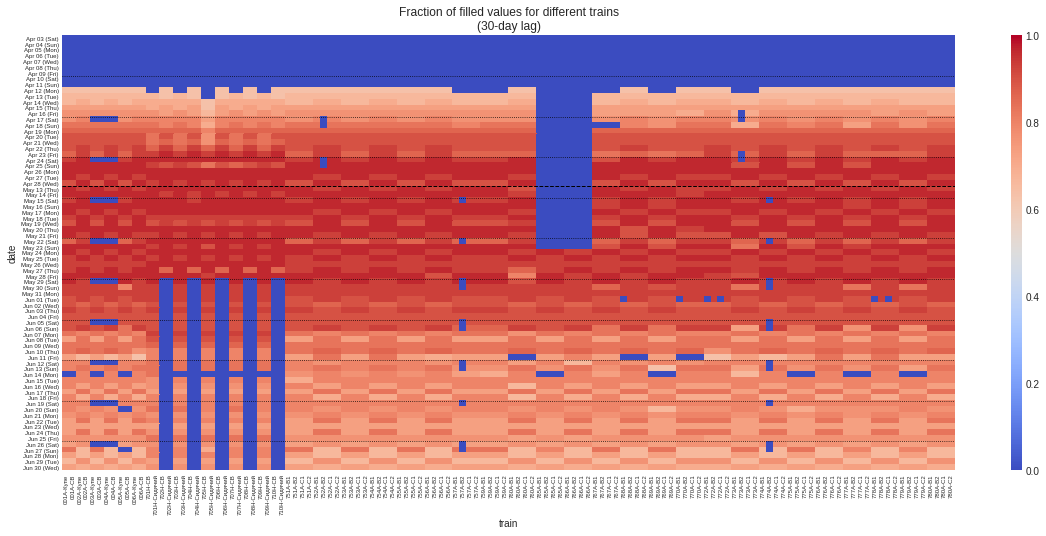

In [63]:
filled_frac = pd.DataFrame({
    train: data[(data['train'] == train) & (data['days'] <= 30)]\
                    .pivot(index='date', columns='days', values='places')\
                    .notna().mean(axis=1)
    for train in sorted(data['train'].unique())
}).reindex(dates).fillna(0)
filled_frac.index = filled_frac.index.map(date_formatter)

ax = plt.figure(figsize=(20, 8)).gca()
sns.heatmap(filled_frac, vmin=0, vmax=1, ax=ax, xticklabels=True, yticklabels=True,
            cmap='coolwarm', cbar_kws={'aspect': 40})

ax.axhline(split_id, c='k', ls='dashed', lw=1)

for i in np.arange(0, filled_frac.shape[0], 7)[1:]:
    ax.axhline(i, c='k', ls='dotted', lw=0.8)

ax.set_xlabel('train')
ax.tick_params(axis='both', which='major', labelsize=6)

ax.set_title('Fraction of filled values for different trains\n'
             '(30-day lag)')

plt.savefig('../data/figures/filled_frac_clean.pdf', transparent=True, bbox_inches='tight')
# plt.close()

### Вместимость каждого поезда в зависимости от даты

In [68]:
capacity = data.groupby(['train', 'date'])['places'].max().reset_index()\
    .pivot(index='date', columns='train', values='places')\
    .reindex(dates).fillna(0)
capacity /= capacity.max()

capacity.head(2)

train,001А-Купе,001А-СВ,002А-Купе,002А-СВ,003А-Купе,003А-СВ,004А-Купе,004А-СВ,005А-Купе,005А-СВ,...,778А-C1,778А-C2,779А-B1,779А-B2,779А-C1,779А-C2,780А-B1,780А-B2,780А-C1,780А-C2
date,,,,,,,,,,,,,,,,,,,,,
2021-04-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-04-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


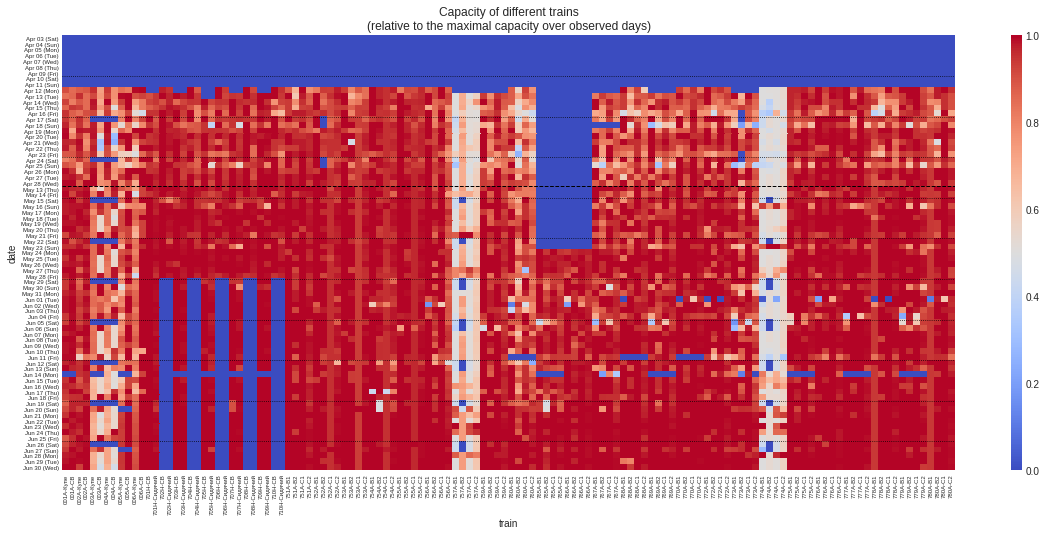

In [69]:
capacity_ = capacity.copy()
capacity_.index = capacity_.index.map(date_formatter)

ax = plt.figure(figsize=(20, 8)).gca()
sns.heatmap(capacity_, ax=ax, xticklabels=True, yticklabels=True,
            cmap='coolwarm', cbar_kws={'aspect': 40})

ax.axhline(split_id, c='k', ls='dashed', lw=1)

for i in np.arange(0, capacity_.shape[0], 7)[1:]:
    ax.axhline(i, c='k', ls='dotted', lw=0.8)

ax.set_xlabel('train')
ax.tick_params(axis='both', which='major', labelsize=6)

ax.set_title('Capacity of different trains\n'
             '(relative to the maximal capacity over observed days)')

plt.savefig('../data/figures/capacity.pdf', transparent=True, bbox_inches='tight')
# plt.close()

### Удаляем для некоторых поездов даты, в которые количество вагонов существенно отличается

Белые пятна на картинке выше свидетельствуют о том, что в отдельные дни администрацией РЖД меняется количество вагонов у поезда. Такого рода ситуации надо обрабатывать отдельно. Пока что просто выкидываем.

In [85]:
mask = data['train'].isin(['003А-СВ', '004А-СВ'])

data = data[~mask].copy()

mask.sum()

12356

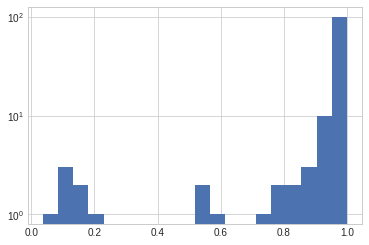

In [95]:
prevailing_capacity = {}

for train in capacity.columns:
    train_capacity = capacity[train].copy()
    train_capacity = train_capacity[train_capacity > 0]
    prevailing_capacity[train] = (train_capacity >= 0.7).mean()
    
prevailing_capacity = pd.Series(prevailing_capacity)

prevailing_capacity.hist(bins=20)
plt.yscale('log')

In [94]:
prevailing_capacity[prevailing_capacity]

{'001А-Купе': 1.0,
 '001А-СВ': 1.0,
 '002А-Купе': 0.9696969696969697,
 '002А-СВ': 1.0,
 '003А-Купе': 0.8571428571428571,
 '003А-СВ': 0.5357142857142857,
 '004А-Купе': 0.8070175438596491,
 '004А-СВ': 0.5263157894736842,
 '005А-Купе': 0.7936507936507936,
 '005А-СВ': 0.9682539682539683,
 '006А-Купе': 0.8181818181818182,
 '006А-СВ': 0.9848484848484849,
 '701Н-СВ': 1.0,
 '701Н-Сидячий': 1.0,
 '702Н-СВ': 1.0,
 '702Н-Сидячий': 1.0,
 '703Н-СВ': 1.0,
 '703Н-Сидячий': 1.0,
 '704Н-СВ': 1.0,
 '704Н-Сидячий': 1.0,
 '705Н-СВ': 1.0,
 '705Н-Сидячий': 0.9682539682539683,
 '706Н-СВ': 1.0,
 '706Н-Сидячий': 1.0,
 '707Н-СВ': 1.0,
 '707Н-Сидячий': 0.953125,
 '708Н-СВ': 1.0,
 '708Н-Сидячий': 1.0,
 '709Н-СВ': 1.0,
 '709Н-Сидячий': 0.984375,
 '710Н-СВ': 1.0,
 '710Н-Сидячий': 0.9696969696969697,
 '751А-B1': 1.0,
 '751А-B2': 0.9545454545454546,
 '751А-C1': 1.0,
 '751А-C2': 1.0,
 '752А-B1': 1.0,
 '752А-B2': 1.0,
 '752А-C1': 1.0,
 '752А-C2': 0.9848484848484849,
 '753А-B1': 1.0,
 '753А-B2': 0.9696969696969697,
 '75

In [17]:
mask = data['train'].isin(['005А-Купе', '006А-Купе'])\
    & (data['date'].dt.weekday == 4)

print(mask.sum())

data = data[~mask].copy()

1030


In [18]:
mask = (data['train'] == '005А-Купе')\
    & (data['date'].dt.weekday == 6)

print(mask.sum())

data = data[~mask].copy()

530


In [19]:
mask = data['num'].isin(['705Н', '707Н'])\
    & data['class'].str.startswith('Сидячи')\
    & (data['date'].dt.weekday == 6)

print(mask.sum())

data = data[~mask].copy()

1063


In [20]:
mask = (data['train'] == '773А-B2') & data['date'].dt.weekday.isin([5, 6])

print(mask.sum())

data = data[~mask].copy()

981


In [21]:
mask = (data['train'].isin(['752А-B2', '757А-B2', '760А-B2', '774А-B2']))\
    & data['date'].dt.weekday.isin([4, 5])

print(mask.sum())

data = data[~mask].copy()

3080


In [22]:
mask = (data['num'] == '757А') & data['date'].dt.weekday.isin([3, 4])

print(mask.sum())

data = data[~mask].copy()

3387


In [23]:
mask = (data['num'] == '774А') & (data['date'].dt.weekday == 6)

print(mask.sum())

data = data[~mask].copy()

1841


In [24]:
data['train'].nunique()

116

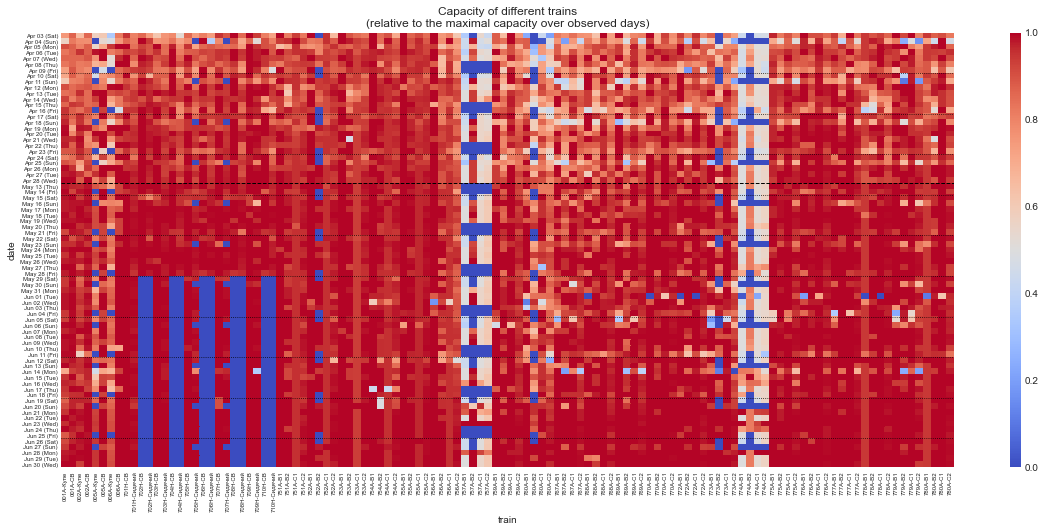

In [25]:
capacity = data.groupby(['train', 'date'])['places'].max().reset_index()\
    .pivot(index='date', columns='train', values='places')\
    .reindex(dates).fillna(0)
capacity /= capacity.max()
capacity.index = capacity.index.map(date_formatter)

ax = plt.figure(figsize=(20, 8)).gca()
sns.heatmap(capacity, ax=ax, xticklabels=True, yticklabels=True,
            cmap='coolwarm', cbar_kws={'aspect': 40})

ax.axhline(split_id, c='k', ls='dashed', lw=1)

for i in np.arange(0, filled_frac.shape[0], 7)[1:]:
    ax.axhline(i, c='k', ls='dotted', lw=0.8)

ax.set_xlabel('train')
ax.tick_params(axis='both', which='major', labelsize=6)

ax.set_title('Capacity of different trains\n'
             '(relative to the maximal capacity over observed days)')

plt.savefig('../data/figures/capacity_clean.pdf', transparent=True, bbox_inches='tight')
# plt.close()

### Данные по дням недели

In [26]:
data['weekday'] = data['date'].dt.weekday
data['day_name'] = data['date'].dt.day_name()

weekdays = data[['weekday', 'day_name']].drop_duplicates().sort_values(by='weekday')\
    .set_index('weekday')['day_name'].to_dict()

weekdays

{0: 'Monday',
 1: 'Tuesday',
 2: 'Wednesday',
 3: 'Thursday',
 4: 'Friday',
 5: 'Saturday',
 6: 'Sunday'}

In [27]:
trains = data['train'].drop_duplicates().sort_values().values
len(trains)

116

In [28]:
ncols = 6
nrows = len(trains) // ncols + (len(trains) % ncols > 0)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(3 * ncols, 3 * nrows)
fig.subplots_adjust(wspace=0.4, hspace=0.5)
axes = axes.flatten()

for train, ax in zip(trains, axes):
    train_data = data[data['train'] == train]\
        .pivot(index='date', columns='days', values='places')
    
    for date, row in train_data.iterrows():
        weekday = date.weekday()
        
        _, labels = ax.get_legend_handles_labels()
        
        label = weekdays[weekday]
        
        if label in labels:
            label = None
        
        ax.plot(row, c=f'C{weekday}', lw=0.5, label=label)
    
    ax.set_title(train)
    ax.invert_xaxis()
    
for i in range(1, nrows, 3):
    axes[(i + 1) * ncols - 1].legend(loc='upper left', bbox_to_anchor=(1, 1))

for i in range(len(trains), len(axes)):
    axes[i].axis('off')
    
plt.savefig('../data/figures/places_vs_weekday.pdf', transparent=True, bbox_inches='tight')
plt.close()

No handles with labels found to put in legend.


### Точечные исправления данных, где это возможно

Несколько явно мусорных значений.

In [29]:
for train in ['757А-C1', '770А-C1']:
    for date, days in [
        (datetime(year=2021, month=5, day=16), 32),
        (datetime(year=2021, month=5, day=23), 39),
    ]:
        mask = (data['train'] == train)\
            & (data['date'] == date)\
            & (data['days'] == days)
        
        data.loc[mask, 'places'] = np.nan

In [30]:
for train in ['757А-C1', '757А-C1']:
    mask = (data['train'] == train)\
        & (data['date'] == datetime(year=2021, month=4, day=14))\
        & (data['days'] == 1)
    
    data.loc[mask, 'places'] = np.nan

In [31]:
data = data.dropna(subset=['places', 'price'], how='all')

Есть несколько поездов, в которых число вагонов явно увеличивалось извне (т.е. со стороны РЖД) в ходе приближения даты отправления. Такие поезда пока выкидываем, потому что это особенность, с которой пока не ясно, как работать.

In [32]:
trains_to_remove = ['001А-СВ', '002А-СВ', '005А-Купе', '006А-Купе']

data = data[~data['train'].isin(trains_to_remove)].copy()

In [33]:
mask = (data['train'].isin(['774А-B1', '774А-C1', '774А-C2']))\
    & data['date'].dt.weekday.isin([3, 4])

print(mask.sum())

data = data[~mask].copy()

2952


In [34]:
trains = data['train'].drop_duplicates().sort_values().values
len(trains)

112

In [35]:
ncols = 6
nrows = len(trains) // ncols + (len(trains) % ncols > 0)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(3 * ncols, 3 * nrows)
fig.subplots_adjust(wspace=0.4, hspace=0.5)
axes = axes.flatten()

for train, ax in zip(trains, axes):
    train_data = data[data['train'] == train]\
        .pivot(index='date', columns='days', values='places')
    
    for date, row in train_data.iterrows():
        weekday = date.weekday()
        
        _, labels = ax.get_legend_handles_labels()
        
        label = weekdays[weekday]
        
        if label in labels:
            label = None
        
        ax.plot(row, c=f'C{weekday}', lw=0.5, label=label)
    
    ax.set_title(train)
    ax.invert_xaxis()
    
for i in range(1, nrows, 3):
    axes[(i + 1) * ncols - 1].legend(loc='upper left', bbox_to_anchor=(1, 1))

for i in range(len(trains), len(axes)):
    axes[i].axis('off')
    
plt.savefig('../data/figures/places_vs_weekday_clean.pdf', transparent=True, bbox_inches='tight')
plt.close()

In [36]:
for train in data['train'].unique():
    mask = data['train'] == train
    data.loc[mask, 'places_frac'] = data.loc[mask, 'places'] / data.loc[mask, 'places'].max()
    
data.head(2)

,date,days,places,price,num,class,train,departure_timestamp,arrival_timestamp,weekday,day_name,places_frac
0,2021-04-03,1,62.0,3275.0,001А,Купе,001А-Купе,86100.0,28500.0,5,Saturday,0.442857
1,2021-04-04,1,33.0,3913.0,001А,Купе,001А-Купе,86100.0,28500.0,6,Sunday,0.235714


***

In [37]:
data.to_csv('../data/data.csv', index=False, encoding='utf-8')

In [38]:
!jupyter nbconvert --to html 1_preprocessing_eda.ipynb

[NbConvertApp] Converting notebook 1_preprocessing_eda.ipynb to html
[NbConvertApp] Writing 956075 bytes to 1_preprocessing_eda.html
